In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib.markers import MarkerStyle
from scipy.optimize import curve_fit
import os

In [17]:
PX_PER_MM = 7.532343134764206
FRAME_PER_SECOND = 60

plt.style.use("default")
COLOR = 'black'

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 50
rcParams['axes.grid'] = True
rcParams['axes.xmargin'] = 0
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR


# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 36
rcParams['ytick.labelsize'] = 22
rcParams['xtick.labelsize'] = 22
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

# SAVE
# rcParams['savefig.format'] = 'pdf'
rcParams['savefig.bbox'] = 'tight'
# rcParams['savefig.pad_inches'] = 0.05

## x(t)

In [18]:
df_x_t = pd.read_csv('datos\\ECO20-45mm\\cabeza\\1,00Vpp-3Hz.csv')
v = '1,00Vpp' 
vval = 1.0
f = '3Hz'
t,x,y = np.array(df_x_t['t']/FRAME_PER_SECOND), np.array(df_x_t['x']/PX_PER_MM), df_x_t['y']/PX_PER_MM
# x_recentered = x - (x[0]-avg_start)

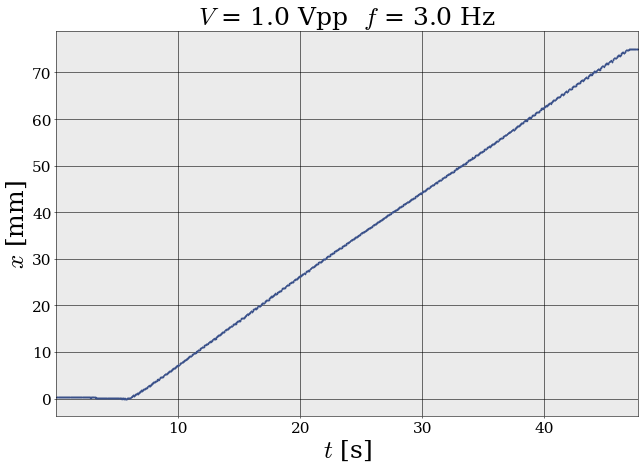

In [22]:
norm = plt.Normalize(0.5,2.5)
cmap = plt.colormaps.get_cmap('viridis')
colorscale = plt.cm.ScalarMappable(norm, cmap)

fig, axis = plt.subplots()
axis.plot(t, -x + np.max(x), '.', markersize = 2,  color = cmap(norm(vval)) )
axis.set_title('$V$ = 1.0 Vpp  $f$ = 3.0 Hz')
axis.set_xlabel(r'$t$ [s]')
axis.set_ylabel(r'$x$ [mm]')

fig.savefig(f'gráficos\\x(t)_1Vpp_3Hz.png')

## Velocidad terminal en función de f y V

### Pendientes para la cabeza

In [14]:
#We prepare a dataframe of all our filenames and a dataframe of all our csv's
csv_names = [filepath for filepath in os.listdir('datos\\ECO20-45mm\\cabeza pendiente') if '.csv' in filepath]
filenamelist = pd.DataFrame().assign(name = csv_names)
df = [pd.read_csv(f'datos\\ECO20-45mm\\cabeza pendiente\\{f}') for f in filenamelist['name']]

In [21]:
f_lineal = lambda x,a,b: a*x + b

#Creating the colormap
norm_v = plt.Normalize(0.5,2.5)
cmap_v = plt.colormaps.get_cmap('viridis')
colorscale_v = plt.cm.ScalarMappable(norm_v, cmap_v)

norm_f = plt.Normalize(2,10)
cmap_f = plt.colormaps.get_cmap('viridis')
colorscale_f = plt.cm.ScalarMappable(norm_f, cmap_f)

freq_marker = MarkerStyle("o", fillstyle="left")
volt_marker = MarkerStyle("o", fillstyle="right")

currVolt_array = ['500mVpp','1,00Vpp','1,50Vpp','2,00Vpp','2,50Vpp'] #We create a volt tag array

### Pendiente en función de frecuencia

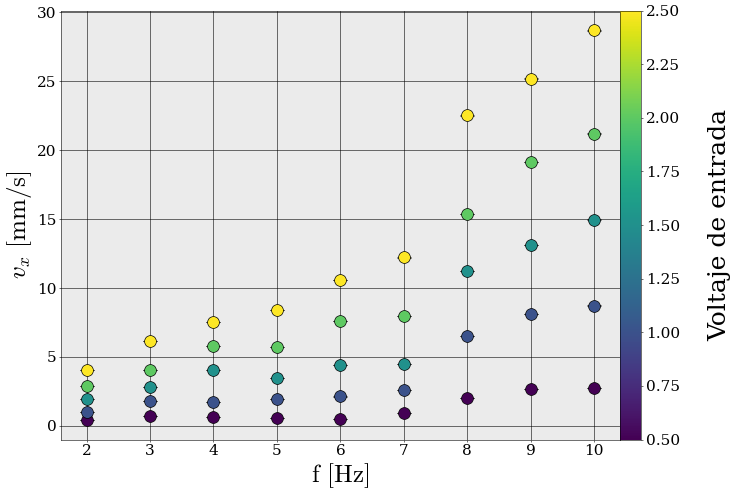

In [16]:
fig, ax = plt.subplots()

for currVolt in currVolt_array:

    df_namelist = filenamelist[filenamelist['name'].str.contains(currVolt)] #We get the filenames corresponding to the voltage chosen
    filtered_namelist = df_namelist['name'] #We get the names of those files


    for filename in filtered_namelist:
        
        df_txy = df[ df_namelist[df_namelist['name']==filename].index[0] ] #We retrieve the dataframe corresponding to our current filename
        
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('.')[0].split('-')
        v,f = s[0],s[1]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        fval = float(f.split('Hz')[0].replace(',','.'))
        
        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))
        
        #We retrieve the data from our dataframe
        t,x = df_txy['t'], df_txy['x']
    
        x = -x + np.max(x)
        
        popt, popv = curve_fit(f_lineal, t, x)
        
        err_popt = np.sqrt(np.diag(popv))
        # print(f' {v}-{f} => parametros: {popt[0]}, {popt[1]} ; errores: {err_popt[0]}, {err_popt[1]} ')
        
        # Plotting
        ax.errorbar(fval, popt[0], markerfacecolor = volt_color, fmt='o',
                    yerr = err_popt[0], xerr = None, color = 'k', ecolor = 'k',
                    ms=17, elinewidth=2, lw=3, capsize=10)
    ax.plot(fval, popt[0], color = volt_color)
        # ax.errorbar(vval, popt[0], markerfacecolor = freq_color, fmt='o',
        #         yerr = err_popt[0], xerr = None, color = 'k', ecolor = 'k',
        #         ms=20, elinewidth=2, lw=3, capsize=10)

        
# Colorbar configuration

cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0)
cbar_term.ax.set_ylim(0.5,2.5)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)


# cbar_term = fig.colorbar(colorscale_f, ax=ax, location='right', orientation='vertical', pad=0)
# cbar_term.ax.set_ylim(2,10)
# cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
# cbar_term.ax.set_ylabel('Frecuencia de forzado',labelpad=40)


#Axes configuration
ax.set_xlabel(f'$\\text{{f}}$ $[\\text{{Hz}}]$')
ax.set_ylabel(f'$v_x$ $[\\text{{mm/s}}]$')

fig.tight_layout()
# fig.savefig(f'pendiente-en-funcion-de-frecuencia.svg', bbox_inches='tight')
fig.savefig('gráficos\\slope(f,V) sin 3366.png')